**Recurrent Neural Networks applied to Speech Recognition**

*ML class Exam - 11th January 2021*

Ravel BASSIL

# **Introduction**

Recurrent Neural Networks (RNNs) have always been powerful models when it comes to sequential data. So in problems such as handwriting or speech recognition, it is only natural to consider applying them given that speech, whether written or spoken, is an inherently dynamic process. However, the history of RNNs applied to speech recognition hasn't been the most successful. Deep Neural Networks, in combination with hidden Markov models (HMMs) have instead taken the spotlight when it comes to speech recognition.

In the recent years, numerous researchers have taken the time to further explore the application of RNNs to Automatic Speech Recognition (ASR) with contrasting results. For example, the combination of HMMs with RNNs was recently explored by [O. Vinyals *et al.*](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6288816) and [A. Maas *et al.*](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/45168.pdf) but do not currently perform as well as deep networks, while [A. Graves *et al.*](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6638947) investigated whether RNN could benefit from depth in space and their work yielded promising results for 'end-to-end' recognition (from acoustic inputs to sequenced text outputs).

Speech Recognition can come in many aspects. In the past, RNNs were used as intermediate models in the general ASR model (encoding model, language model, decoding model etc...), but the recent trend is to use RNNs for 'end-to-end' training (E2E), meaning from the acoustic sequence input to the text sequence output.

In this notebook, we will go through the application of RNNs to ASR, essentially E2E ASR, from the extraction (or encoding) of the raw audiofiles to the training of the model, focusing on the most promising methods and architectures based on the articles I could find and read on the subject. This paper is presented as follows: Section I will deal with the analysis and preprocessing of the data, Section II will look into RNN architectures applied to ASR, training methods are discussed in Section III and finally, Section IV will present some of the results of modern works in the field.

# **I. Data Preprocessing**

In this part, we will be looking at the data used and the preprocessing steps needed before applying any RNN model.

> *I.1 Taking a look at the audio data*

For this notebook, we will use the dataset of the DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus ([download link](https://deepai.org/dataset/timit)). TIMIT contains a total of 6300 sentences, 10 sentences spoken by each of 630 speakers from 8 major dialect regions of the United States, named "DR1" to "DR8". As the dataset is very large and since it is recommanded to use Google Colab for RNNs applications, we will limit the work of this notebook to only the data of region "DR1". This way, you only have to upload the train data and test data of "DR1" to your Drive. 

*Note: if you accessed this notebook using Google Drive's link, the data file should be in the directory, in the folder 'data'. If you are running this notebook locally on your PC, you don't necessarily need to upload the notebook and the data to your Drive (time consuming). No heavy RNN models are built or trained in this notebook, so GPU running might not be necessary unless you would like to develop your own model and try it yourself.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
from scipy import signal
from scipy.io import wavfile
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import librosa
import librosa.display

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/SpeechRecRNN/' ### make sure the path to your notebook is correct
train_data_path = PATH + 'train_data.csv'
test_data_path = PATH + 'test_data.csv'

*make sure to adjust the PATH to your current repository*

In [ ]:
# Choosing the DR you want to work with. 
DR1 = 'DR1'

# Getting the train and test datasets
train_df = pd.read_csv(train_data_path)
train_df = train_df[train_df['dialect_region']==DR1]

test_df = pd.read_csv(test_data_path)
test_df = test_df[test_df['dialect_region']==DR1]

Let's have a look at the training dataset:

In [ ]:
train_df.head(20)

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
20100,20101.0,TRAIN,DR1,FECD0,SX338.TXT,TRAIN/DR1/FECD0/SX338.TXT,TRAIN\\DR1\\FECD0\\SX338.TXT,False,False,False,NaN,True
20101,20102.0,TRAIN,DR1,FECD0,SX338.WAV,TRAIN/DR1/FECD0/SX338.WAV,TRAIN\\DR1\\FECD0\\SX338.WAV,False,True,False,NaN,False
20102,20103.0,TRAIN,DR1,FECD0,SX248.WAV,TRAIN/DR1/FECD0/SX248.WAV,TRAIN\\DR1\\FECD0\\SX248.WAV,False,True,False,NaN,False
20103,20104.0,TRAIN,DR1,FECD0,SX248.TXT,TRAIN/DR1/FECD0/SX248.TXT,TRAIN\\DR1\\FECD0\\SX248.TXT,False,False,False,NaN,True
20104,20105.0,TRAIN,DR1,FECD0,SI2048.TXT,TRAIN/DR1/FECD0/SI2048.TXT,TRAIN\\DR1\\FECD0\\SI2048.TXT,False,False,False,NaN,True
20105,20106.0,TRAIN,DR1,FECD0,SI1418.WAV.wav,TRAIN/DR1/FECD0/SI1418.WAV.wav,TRAIN\\DR1\\FECD0\\SI1418.WAV.wav,True,True,False,NaN,False
20106,20107.0,TRAIN,DR1,FECD0,SX428.TXT,TRAIN/DR1/FECD0/SX428.TXT,TRAIN\\DR1\\FECD0\\SX428.TXT,False,False,False,NaN,True
20107,20108.0,TRAIN,DR1,FECD0,SX158.TXT,TRAIN/DR1/FECD0/SX158.TXT,TRAIN\\DR1\\FECD0\\SX158.TXT,False,False,False,NaN,True
20108,20109.0,TRAIN,DR1,FECD0,SI788.WAV.wav,TRAIN/DR1/FECD0/SI788.WAV.wav,TRAIN\\DR1\\FECD0\\SI788.WAV.wav,True,True,False,NaN,False
20109,20110.0,TRAIN,DR1,FECD0,SI2048.WAV,TRAIN/DR1/FECD0/SI2048.WAV,TRAIN\\DR1\\FECD0\\SI2048.WAV,False,True,False,NaN,False


As you can see in this dataset, we have the raw audio file (.wav) and its target is provided in multiple forms: the .TXT file provides the sentence with its debut timeframe number and end timeframe number while the .WRD file provides the lists of words, each with its debut and end timeframe number. Feel free to go through the data files to have a look at the different files provided.

Obviously, the raw audio files cannot be given as they are for a model. They need to be 'featurized' or 'vectorized'.


> *I.2 Featurizing the data*

There are multiple ways to transform the raw audio file into a vector of numbers that can be understood by a model. In this notebook, we will look at the two methods that I encountered the most during my preparation: the spectrogram representation and the Mel-Frequency Cepstral Coefficients (or MFCCs). We will firstly explore the spectrogram representation. For more about deep learning architectures that can accept raw audio input, you can explore this [research paper](https://www.semanticscholar.org/paper/Learning-the-speech-front-end-with-raw-waveform-Sainath-Weiss/fd5474f21495989777cbff507ecf1b37b7091475?p2df).


Each timeframe of the audio can be characterized by the spectrogram of the sound at this moment. The spectrogram gives for each frequency its amplitude. Now since the range of frequency is a continuous interval, the amplitudes are going to be grouped in ranges of 50 (usually) frequencies, and ranging from 0 to 8000Hz (usually). That makes a spectrogram vector of about 160 amplitudes for each timeframe. The spectrogram representation gives the vector of spectrograms for each timeframe in the audio.

Enough with the talk. Let's see what this method does in practice:

In [ ]:
# choose an audio file
audiofile = train_df[train_df['is_converted_audio']].iloc[0]
filename = audiofile['filename']
audio_path = PATH + 'data/' + audiofile['path_from_data_dir']

In [ ]:
# read the audio file
sample_rate, samples = wavfile.read(audio_path)

In [ ]:
# defining a function that computes the spectrogram
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
# compute the spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

# show the spectrogram
print(spectrogram)
print('Audio file {} has {} frames'.format(filename, len(spectrogram)))
print('Each frame has {} amplitudes'.format(len(spectrogram[0])))

[[ -6.241168   -2.6484115  -6.841922  ...  -7.3896036  -5.940238
  -10.287086 ]
 [ -2.0429478  -2.0762155  -5.2451053 ...  -5.994064   -5.6039248
   -5.8690734]
 [ -1.0166712  -0.7132708  -2.2764223 ...  -7.8046923 -10.85034
  -13.045085 ]
 ...
 [ -4.4606943  -4.686606   -6.836191  ...  -8.420785   -8.016431
  -10.977629 ]
 [ -4.690646   -4.7925572  -5.8609705 ...  -7.4763436  -7.270456
   -8.751095 ]
 [ -5.885778   -6.1185956  -8.613677  ... -11.64009    -9.535638
  -12.467886 ]]
Audio file SI1418.WAV.wav has 556 frames
Each frame has 161 amplitudes


Now let's visualise the spectrogram and the audio file

Text(0.5, 0, 'Seconds')

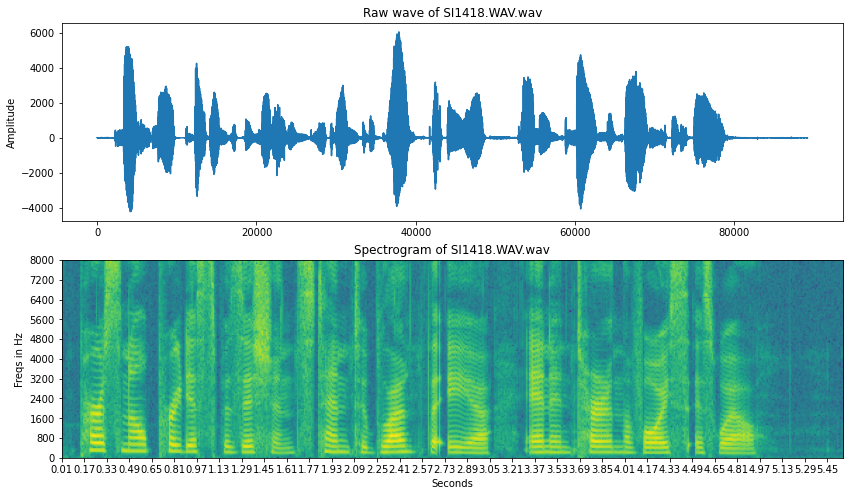

In [ ]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(start=0, stop=len(samples), num=len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

*Remark*

There is an interesting fact to point out. We have ~160 features for each frame, frequencies are between 0 and 8000Hz. It means, that one feature corresponds to 50 Hz. However, frequency resolution of the ear is 3.6 Hz within the octave of 1000 – 2000 Hz It means, that people are far more precise and can hear much smaller details than those represented by spectrograms like above.

After obtaining the spectrograms, a good idea is to normalize them before giving them to a RNN model. We do so by retrieving the mean and dividing by the standard deviation, which is not the best normalization out there.

In [ ]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

Now that we saw what is the spectrogram representation, let's explore the MFCC representation

The idea of the MFCC is based on the fact that the sounds generated by a human are filtered by the shape of the vocal tract including tongue, teeth etc. This shape determines what sound comes out. If we can determine the shape accurately, this should give us an accurate representation of the phoneme being produced. The shape of the vocal tract manifests itself in the envelope of the short time power spectrum, and the job of the coefficients of the Mel-Frequency Cesptrum is to accurately represent this envelope. More detailed information can be found on [this page](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

Let's try it and see the results.

In [ ]:
samples, sample_rate = librosa.load(audio_path)
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

In [ ]:
print(S)
print('Audio file {} has {} frames'.format(filename, len(S)))
print('Each frame has {} amplitudes'.format(len(S[0])))

[[1.99583551e-04 3.74958327e-04 2.56736502e-04 ... 2.72840037e-06
  4.13225059e-06 9.08195483e-07]
 [5.00002829e-05 1.22784072e-04 1.01079182e-04 ... 8.61813653e-07
  1.30549359e-06 5.76142541e-07]
 [5.39603407e-06 8.14433051e-06 4.91573775e-06 ... 3.11311440e-07
  7.70540299e-07 1.83292263e-06]
 ...
 [7.49595383e-16 1.87594468e-16 1.71094808e-19 ... 2.12108775e-20
  1.17645990e-11 5.90779939e-11]
 [1.35461471e-15 3.38793556e-16 1.33438014e-19 ... 1.42311039e-20
  1.15021821e-11 5.77602152e-11]
 [1.84394624e-15 4.61109166e-16 1.18451185e-19 ... 1.87105589e-20
  1.13394865e-11 5.69431960e-11]]
Audio file SI1418.WAV.wav has 128 frames
Each frame has 241 amplitudes


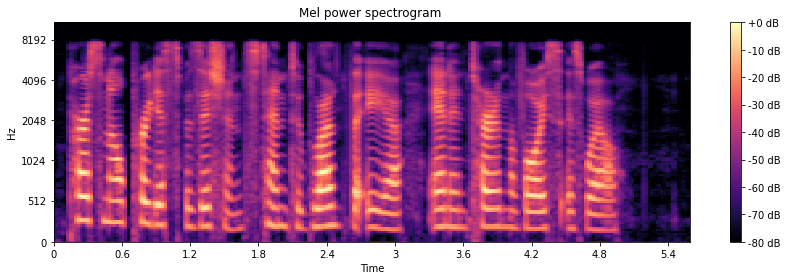

In [ ]:
# Plotting the spectrogram: convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

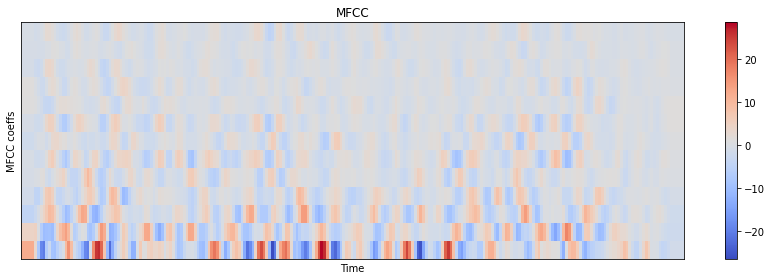

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Plotting the coefficients: Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

MFCC can be very useful in speech recognition since it focuses on phonemes rather than pronounced letters. Phonemes caracterise the pronounciation of a word better than single letters since they are unique. For example, the verb to "live" and the adjective "live" are written the same, but pronounced differently. The file TIMITDIC.TXT of the TIMIT corpus contains the phonemes caracterising each word used in the dataset.

Keep in mind that there are multiple other representations possible. Data scientists often adapt their representation to better suit their needs.

> *Extracting the labels*

As for the input data, the output labels have to be processed as well. It could be possible to attribute a class to each and every word used in the dataset, but there are around 6 thousands of them, so this might not be the best option. Plus, a word can be pronounced over many successive frames which makes it very complicated to teach the model anything about a frame. In other words, forcing a frame to produce a word is in most cases incorrect.

A better option is to train the model to recognise phonemes or letters rather that words. A phoneme (or letter) can be pronounced over many successive frames, but at least these frames will have similar features and it will therefore be possible to teach the model something about the phoneme (or letter). Moreover, with the MFCC representation, we a have a method well-suited for recognising phonemes. In this notebook, we decided to go with letter recognition rather than phoneme, just to make the work simpler.

One sure thing is that attributing a letter to each frame is not enough to obtain a valid sentence that makes sense. The lengths of the label is not necessarily aligned with the length of the audio file. There probably isn't even any kind of relation (whether proportional or any other...) linking the two lengths which leaves us with zero information on the alignment between the input sequence and the output sequence. We will see later in the notebook how this issue is resolved, but first let's have a look on the preprocessing of labels.

So our model has as many classes as letters in the English alphabet (or phonemes if you decided to work with phonemes), plus a pause character(space) and an apostrophe one ('). At the end of our model architecture, we will get numbers and we will have to decode these numbers into letters and then from these letters, try to get the correct text sequence.



In order to do so, we firslty need an object that stores our letter-to-integer dictionnary, one function for converting a text sequence to a integer sequence and another to do the opposite operation.

In [ ]:
class TextTransform(object):
    """Maps characters to integers and vice versa"""
    def __init__(self):
        """
        Defines two dictionaries for converting 
        between text and integer sequences.
        """

        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """

        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c not in self.char_map:
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, int_sequence):
        """ Convert an integer sequence to text """
        text = []
        for c in int_sequence:
            ch = self.index_map[c]
            text.append(ch)
        return text

Let's try it on a sample from the dataset

In [ ]:
# getting the label filename and filepath
label_filename = filename[:-7] + 'TXT'
p = train_df[train_df['filename']==label_filename].iloc[0]['path_from_data_dir']
label_path = PATH + 'data/' + p

# extracting the label
f = open(label_path)
label = f.readline().split()[2:]    # the first two characters are the debut and end frame numbers
strippedlabel = ''
for v in label:
  v = v.strip(',').strip(':').strip(';').strip('?').strip('!')
  strippedlabel = strippedlabel + v + ' '
strippedlabel = strippedlabel.strip()
strippedlabel = strippedlabel.strip('.')
strippedlabel = strippedlabel.lower()    # replacing capital letters with uncapital ones

In [ ]:
# let's see what the sentence is...
print("Label sentence:")
print(strippedlabel)

#... and its integer transformation
text_transform = TextTransform()
int_transformation = text_transform.text_to_int(strippedlabel)
print("Label sentence converted to int sequence...:")
print(int_transformation)

# Verifying that the operation is reversible:
print("...and back to text:")
text_back = text_transform.int_to_text(int_transformation)
print(text_back)

# and again...
print(text_transform.int_to_text(text_transform.text_to_int(text_back)))

Label sentence:
personal predispositions tend to blunt the ear and in turn the voice as well
Label sentence converted to int sequence...:
[17, 6, 19, 20, 16, 15, 2, 13, 1, 17, 19, 6, 5, 10, 20, 17, 16, 20, 10, 21, 10, 16, 15, 20, 1, 21, 6, 15, 5, 1, 21, 16, 1, 3, 13, 22, 15, 21, 1, 21, 9, 6, 1, 6, 2, 19, 1, 2, 15, 5, 1, 10, 15, 1, 21, 22, 19, 15, 1, 21, 9, 6, 1, 23, 16, 10, 4, 6, 1, 2, 20, 1, 24, 6, 13, 13]
...and back to text:
['p', 'e', 'r', 's', 'o', 'n', 'a', 'l', ' ', 'p', 'r', 'e', 'd', 'i', 's', 'p', 'o', 's', 'i', 't', 'i', 'o', 'n', 's', ' ', 't', 'e', 'n', 'd', ' ', 't', 'o', ' ', 'b', 'l', 'u', 'n', 't', ' ', 't', 'h', 'e', ' ', 'e', 'a', 'r', ' ', 'a', 'n', 'd', ' ', 'i', 'n', ' ', 't', 'u', 'r', 'n', ' ', 't', 'h', 'e', ' ', 'v', 'o', 'i', 'c', 'e', ' ', 'a', 's', ' ', 'w', 'e', 'l', 'l']
['p', 'e', 'r', 's', 'o', 'n', 'a', 'l', ' ', 'p', 'r', 'e', 'd', 'i', 's', 'p', 'o', 's', 'i', 't', 'i', 'o', 'n', 's', ' ', 't', 'e', 'n', 'd', ' ', 't', 'o', ' ', 'b', 'l', 'u', 'n', '

Okay. Now that the preprocessing is set, let's build a Speech Recognition object in which we will store the data and preprocessing methods.

In [ ]:
class SpeechRec(object):
  def __init__(self, train_df, test_df, feat_dim=161, validation_rate=0.1, minibatch_size=20, DR_list=['DR1']):
    self.regions = DR_list
    self.train_df = train_df
    self.test_df = test_df
    self.feat_dim = feat_dim
    self.minibatch_size = minibatch_size
    self.text_transform = TextTransform()
    self.Indexes_train = None
    self.Indexes_test = None
    # datasets
    self.X_train = None
    self.y_train = None
    self.y_text_train = None
    self.xtrain_lengths = None  
    self.ytrain_lengths = None

    self.X_test = None
    self.y_test = None
    self.y_text_test = None
    self.xtest_lengths = None
    self.ytest_lengths = None

    self.max_x_length = 0



  def load_XY_data(self, train_or_test='train'):
    '''loads the full X, y of training or testing as a DataFrame object in self'''
    '''XY_train_df or XY_test_df have the following columns: Index/Featurisation(spectrogram or MFCC)/Text label/Integer label'''

    if train_or_test == 'train':
      data_audio_df = self.train_df[self.train_df['is_converted_audio']]
      data_df = self.train_df
    elif train_or_test == 'test':
      data_audio_df = self.test_df[self.test_df['is_converted_audio']]
      data_df = self.test_df
    else:
      return "train_or_test arg must be \'train\' or \'test\'"
    
    X, Y_text, Y = [], [], []
    for i in range(data_audio_df['index'].count()):
        # getting input spectrogram
        audio_path = PATH + 'data/' + data_audio_df.iloc[i]['path_from_data_dir']
        sample_rate, samples = wavfile.read(audio_path)
        freqs, times, spectrogram = log_specgram(samples, sample_rate)
        # getting string label
        filename = data_audio_df.iloc[i]['filename']
        label_filename = filename[:-7] + 'TXT'
        p = data_df[data_df['filename']==label_filename].iloc[0]['path_from_data_dir']
        label_path = PATH + 'data/' + p
        f = open(label_path)
        label = f.readline().split()[2:]
        strippedlabel = ''
        for v in label:
          v = v.strip(',').strip(':').strip(';').strip('?').strip('!')
          strippedlabel = strippedlabel + v + ' '
        strippedlabel = strippedlabel.strip()
        strippedlabel = strippedlabel.strip('.')

        #creating input object
        x = spectrogram
        y_text = strippedlabel.lower()
        y = self.text_transform.text_to_int(strippedlabel.lower())
        X.append(x)
        Y_text.append(y_text)
        Y.append(y)

    if train_or_test == 'train':
      self.X_train = X
      self.y_text_train = Y_text
      self.y_train = Y
      self.Indexes_train = data_audio_df.iloc[i]['index']
      print('Training data loading complete')
    else:
      self.X_test = X
      self.y_text_test = Y_text
      self.y_test = Y
      self.Indexes_test = data_audio_df.iloc[i]['index']
      print('Testing data loading complete')

  def adapt_data(self):
      '''transforms the data in order to make all the samples have the same length''' 
      self.max_x_length = max(max([len(s) for s in self.X_train]), max([len(s) for s in self.X_test]))
      self.max_y_length = max(max([len(s) for s in self.y_train]), max([len(s) for s in self.y_test]))

      # initialize the arrays
      Xtrain = np.zeros([len(self.X_train), self.max_x_length, self.feat_dim])
      ytrain = np.zeros([len(self.y_train), self.max_y_length])
      Xtest = np.zeros([len(self.X_test), self.max_x_length, self.feat_dim])
      ytest = np.zeros([len(self.y_test), self.max_y_length])
      xtrain_lengths = np.zeros(len(self.X_train))
      ytrain_lengths = np.zeros(len(self.y_train))
      xtest_lengths = np.zeros(len(self.X_test))
      ytest_lengths = np.zeros(len(self.y_test))

      for i in range(len(self.X_train)):
          Xtrain[i, :len(self.X_train[i]), :] = self.X_train[i]
          ytrain[i, :len(self.y_train[i])] = self.y_train[i]
          xtrain_lengths[i] = len(self.X_train[i])
          ytrain_lengths[i] = len(self.y_train[i])

      for i in range(len(self.X_test)):
          Xtest[i, :len(self.X_test[i]), :] = self.X_test[i]
          ytest[i, :len(self.y_test[i])] = self.y_test[i]
          xtest_lengths[i] = len(self.X_test[i])
          ytest_lengths[i] = len(self.y_test[i])
      
      self.X_train = Xtrain
      self.y_train = ytrain
      self.X_test = Xtest
      self.y_test = ytest
      self.xtrain_lengths = xtrain_lengths
      self.ytrain_lengths = ytrain_lengths
      self.xtest_lengths = xtest_lengths
      self.ytest_lengths = ytest_lengths

# II. RNN model architecture in speech recognition

In this part, we are going to look at various RNN model architectures used by the different papers I have come to read in my preparation, discussing their different aspects and advantages and focusing on the most promising ones. We will start by a quick presentation of how any RNN model will have to work.

So, the model will work in the following way: at each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

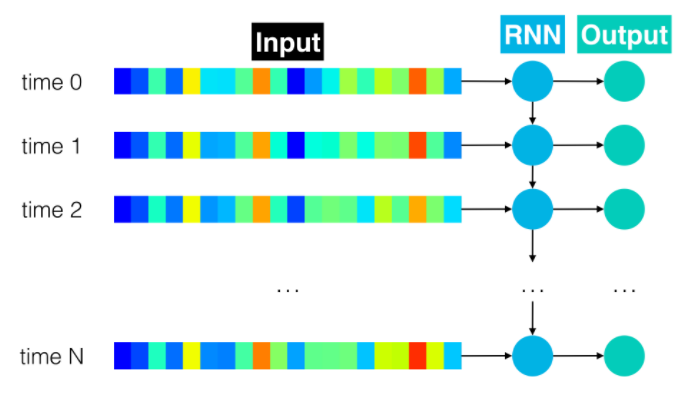

The output of the RNN at each time step is a vector of probabilities with 29 elements, where the $i$-th element encodes the probability that the $i$-th character is spoken in the time sequence. (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.). The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail.

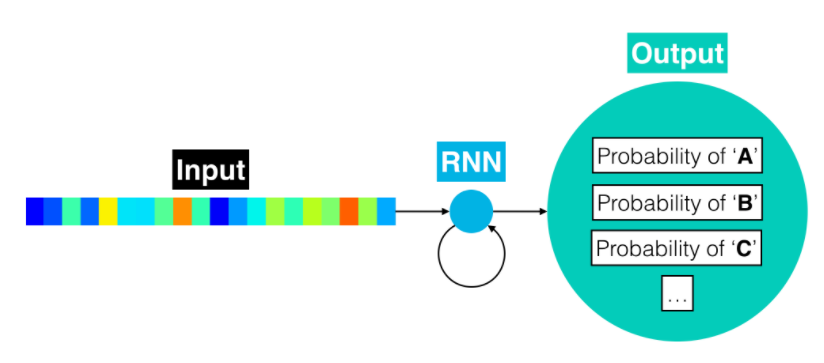

A standard recurrent neural cell has the particular feature of storing its state at the previous iteration. This state is called hidden state and makes the cell particularly good at dealing with sequential data. A standard recurrent neural layer is a layer composed of recurrent neural cells. This layer needs a linear fully connected layer after it to transform the values of the hidden vector into output. Together, we have got a first recurrent neural networks. 

Let's see how it acts on our data.

In [ ]:
# this cell might take some time to run, but it only does the first time if you are on Colab.
SpeechRec = SpeechRec(train_df, test_df)
SpeechRec.load_XY_data('train')
SpeechRec.load_XY_data('test')
SpeechRec.adapt_data()

Training data loading complete
Testing data loading complete


In [ ]:
rnn = nn.RNN(input_size=161, hidden_size=28, num_layers=1, nonlinearity='tanh', batch_first=True, dropout=0, bidirectional=False).double()
X_train = torch.from_numpy(SpeechRec.X_train).to(torch.double)
output, h_n = rnn(X_train)

When we add multiple recurrent layers stacked one after the other, we obtain a deep recurrent neural network.

In [ ]:
print(output[0])

tensor([[ 0.7215,  1.0000,  0.9977,  ...,  1.0000,  0.9971,  0.9996],
        [ 0.7164,  1.0000,  0.9995,  ...,  0.9999,  0.8667, -0.9483],
        [ 0.9511,  0.9998,  0.9992,  ...,  0.9999,  0.9169, -0.0793],
        ...,
        [ 0.0229,  0.0027, -0.0531,  ..., -0.0443, -0.2913, -0.1242],
        [ 0.0229,  0.0027, -0.0531,  ..., -0.0443, -0.2913, -0.1242],
        [ 0.0229,  0.0027, -0.0531,  ..., -0.0443, -0.2913, -0.1242]],
       dtype=torch.float64, grad_fn=<SelectBackward>)


There is not much sense that we can make from this output for the moment, since we still haven't trained our model, neither have build a decoder function to decode the output into a integer sequence. But it's still good to see how it's built.

Another type of RNN cells, often used in speech recognition and context-sensible subjects, are Long Short-term Memory cells (LSTMs). LSTMs use purpose-built memory cells to store information and are very good at finding and exploiting long range context.

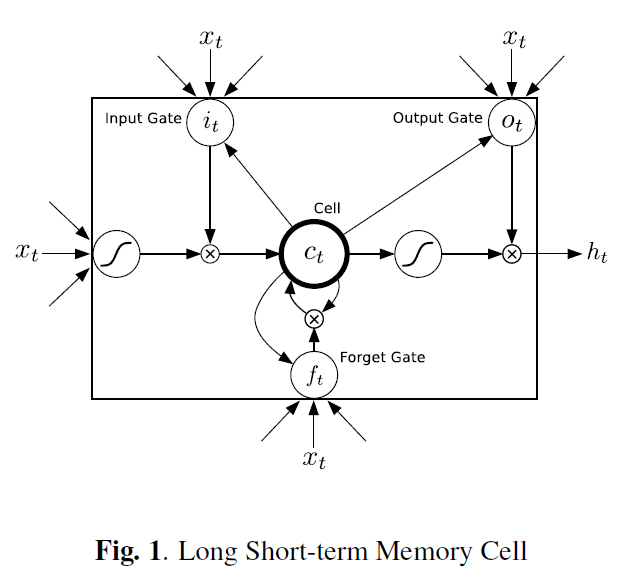

In [ ]:
lstm = nn.LSTM(input_size=161, hidden_size=28, num_layers=2, batch_first=True, bidirectional=False).double()
output, _ = lstm(X_train)
print(output[0])

tensor([[-0.0199, -0.1136, -0.1065,  ..., -0.0224,  0.0438, -0.0477],
        [-0.0249, -0.1668, -0.1512,  ..., -0.0102,  0.0835, -0.0746],
        [-0.0192, -0.1904, -0.1768,  ...,  0.0018,  0.1145, -0.1048],
        ...,
        [ 0.0698, -0.1956, -0.0900,  ..., -0.0928,  0.0546,  0.1137],
        [ 0.0698, -0.1956, -0.0900,  ..., -0.0928,  0.0546,  0.1137],
        [ 0.0698, -0.1956, -0.0900,  ..., -0.0928,  0.0546,  0.1137]],
       dtype=torch.float64, grad_fn=<SelectBackward>)


One shortcoming of conventional RNNs is that they are only able to make use of previous context. The hidden vector used by the RNNs stores only the information on the state of the cell at the previous iteration, which dealt with the previous element of the sequence. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.
Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers, which are fed forwards to the same output layer. These layers are not connected together.

As shown in the figure below (Fig. 2), the forward hidden cell feeds on the previous forward hidden cell and the input cell, whereas the backwards hidden cell feeds on the next backwards hidden cell and the input cell. The output is then computed using both the forward and backward hidden cell. In practice, the BRNN computes the first forward hidden layer and deduces a first estimation of the output by iteration from the beginning of the sequence till its end, and then computes the backward hidden layer and updates the output vector as it iterates again from the end of the sequence till its beginning.

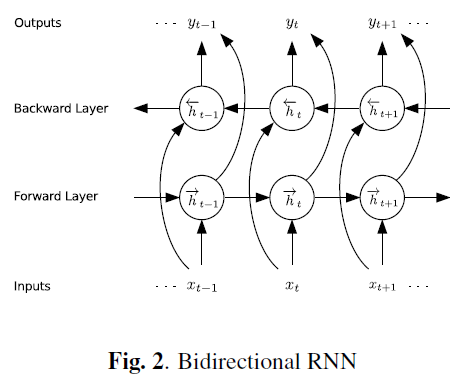

In [ ]:
rnn = nn.RNN(input_size=161, hidden_size=28, num_layers=1, nonlinearity='tanh', batch_first=True, dropout=0, bidirectional=True).double()
output, h_n = rnn(X_train)
print(output[0])

tensor([[ 1.0000,  1.0000, -1.0000,  ..., -0.9729,  1.0000,  0.9908],
        [ 1.0000,  1.0000, -1.0000,  ...,  0.9948,  1.0000,  0.9766],
        [ 1.0000,  1.0000, -1.0000,  ..., -0.4294,  1.0000,  0.4788],
        ...,
        [-0.0213,  0.3357,  0.0522,  ..., -0.2274, -0.0492, -0.1497],
        [-0.0213,  0.3357,  0.0522,  ..., -0.2618, -0.0828, -0.1229],
        [-0.0213,  0.3357,  0.0522,  ..., -0.1883,  0.1573, -0.1486]],
       dtype=torch.float64, grad_fn=<SelectBackward>)


Now when you combine BRNN with LSTM cells, you get Bidirectional LSTMs, which are good at both exploiting long range context and doing it in both directions : past and future.

In [ ]:
lstm = nn.LSTM(input_size=161, hidden_size=28, num_layers=2, batch_first=True, bidirectional=True).double()
output, _ = lstm(X_train)
print(output[0])

tensor([[-0.0290, -0.0662, -0.0381,  ..., -0.1651,  0.1099, -0.2609],
        [-0.0233, -0.1051, -0.0567,  ..., -0.1910,  0.1536, -0.2943],
        [-0.0358, -0.1685, -0.0240,  ..., -0.1492,  0.1426, -0.2616],
        ...,
        [ 0.0418, -0.0249, -0.0352,  ...,  0.0011,  0.0071, -0.0467],
        [ 0.0421, -0.0240, -0.0348,  ...,  0.0031,  0.0072, -0.0394],
        [ 0.0422, -0.0207, -0.0326,  ...,  0.0044,  0.0052, -0.0252]],
       dtype=torch.float64, grad_fn=<SelectBackward>)


One interesting paper, "Speech Recognition with Deep Recurrent Neural Network" by [Alex Graves *et al.*](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6638947) from the University of Toronto, investigated the use of Deep Bidirectional LSTMs in speech recognition. The question that inspired their paper was whether RNNs could benefit not only from depth in time (thanks to the hidden states) but also from depth in space (number of layers). Their results applied to the TIMIT dataset proved very promising and showed a clear benefit of depth in space for RNNs. Their work focused on phoneme recognition and their optimal model resulted in a 17.7% phoneme error rate (PER).

Other architectures, not necessarily exploiting depth in space, are also possible. In [this notebook](https://github.com/yungshun317/keras-rnn-speech-recognizer/blob/master/keras_rnn_speech_recognizer.ipynb?fbclid=IwAR0yII9ItwghqLw5HHVorwaukLVNj4jPZ50bvBZO3UakjmR4U6SOjFHwI1c), the author presents multiple architectures that can be applied to speech recognition. Gated Recurrent Units (GRUs) can be used along with Time Distributed wrappers. These wrappers allow to apply a layer to every temporal slice of an input and they are placed between the RNN layer and the output (see figure below).

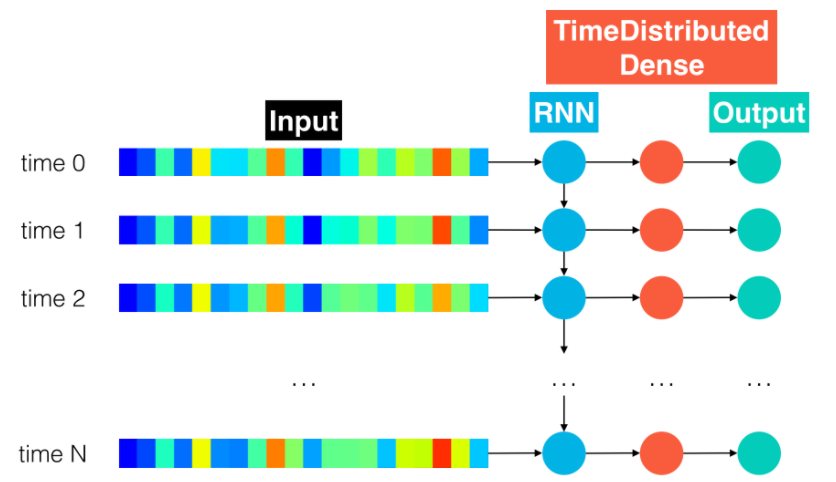

Finally, convolutional layers can be placed before the recurrent layers in the case of big heavy instances. With what we have seen, the range of possible RNN architectures applied to speech recognition is very wide, since it is possible to combine any of the previous architectural elements : LSTM, Bidirectional LSTM, Deep Bidirectional LSTM with a convolutional layer, etc...



# III. Training the model

After building the model, it is now time to train it. The training we are focusing on is end-to-end training (E2E), meaning we teach the model to map directly from the acoustic sequence to the text sequence. Compared to the old-fashioned hybrid approach, in which we have several intermediate models (acoustic, language, lexicon, decision tree etc...), this approach focuses on only one model that computes the final output from the raw initial input. One advantage of this approach is that it removes the need for a predefined and error-prone alignment to create the targets.

We have seen in the last section, that after getting the model's output we still need to deduce the text sequence. Converting the model's integer output to text output isn't enough: one letter can be pronounced over successive frames and the text sequence isn't necessarily of the same length of the input sequence (number of frames). So for a given output of the model, multiple text sequences are possible.

The first step is to use the network outputs to parameterise a differentiable distribution $Pr(y|x)$ over all possible output text sequences $y$ given an acoustic input sequence $x$. The log-probability $log~Pr(z|x)$ of the target output sequence $z$ can then be differentiated with respect to the network weights using backpropagation through time and the whole system can be optimised using an optimizer.

From the most contemporary and mostly used E2E approaches are the Connectionist Temporal Classification (CTC), the Attention Encoder-Decoder (AED) and the RNN Transducer (RNNT). We are going to talk you through all three of them. 

Let $T$ be the length of the input acoustic sequence $x$ and $U$ the one of the the output sequence $z$.

> The Connectionist Temporal Classification

The idea of the CTC method is the introduction of a "blank" character or phoneme. With that, it is no longer necessary to align the input to the output sequence. The model learns by itself whether a certain frame produces a character or not. 

CTC uses a softmax layer to define a separate output distribution, $Pr(k|t)$ at every frame $t$ along the input sequence, with $k$ being one of the 28 possible characters (26 letters from the English alphabet plus the blank character and the apostrophe). The softmax layer is therefore of size 28. CTC then uses a forward-backward algorithm to sum over all possible alignments and determine the normalised probability $log~Pr(z|x)$ of the target sequence.

Similar methods have been used by scientists like [G. Zweig *et al.*](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.149.9632&rep=rep1&type=pdf) in speech and handwriting recognition to consider segmentation. However CTC ignores segmentation altogether and sums over single-timestep label decisions instead.

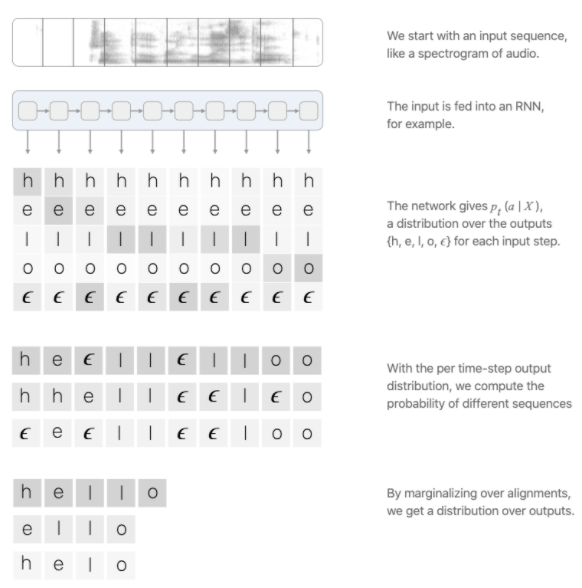


To better understand the CTC algorithm, let's first consider an output label ["c", "a", "t"] with an input length $T$ of 6. We could first try to assign an output to each frame and then collapse repeated letters:

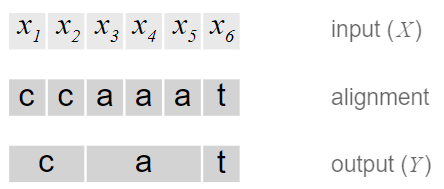

But this technique has two problems: the first one is that it might not make sense to force each frame to produce a character and the second is that there are words with doubled letters ("Hello").

To get around this problem, CTC uses the blank character, often referred to as $\epsilon$. It is simply removed from the output, as in the below figure.

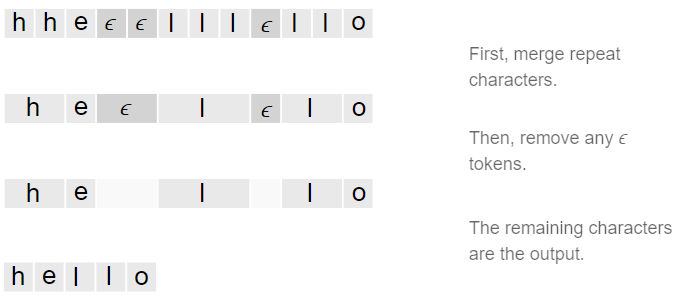

If the output $Y$ has two of the same character in a row, then a valid alignment must have an $\epsilon$ between them. With this rule in place, we can differentiate between alignments which collapse to “hello” and those which collapse to “helo”.

You can find more details on the CTC function in [this paper](https://distill.pub/2017/ctc/).

To train our model with this method, we use the CTCLoss function from Torch:

In [ ]:
criterion = nn.CTCLoss(blank=28)

> RNN Transducers

The RNNT method extends the CTC modelling by incorporating the acoustic model (of a hybrid ASR model) with its encoder, the language model with its prediction network and the decoding process with its joint network. Unlike the CTC method, there is no frame-independence assumption anymore.

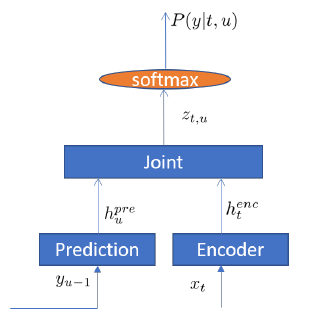

The figure above shows the diagram of the RNN-T model, which consists of the encoder, the prediction model and the joint network. The encoder network is basically the featurization phase, in which the raw audiofile $x_t$ is represented in a higher-dimension space by $h_t^{enc}$, with $t$ being the time. The prediction network works like a RNN language model, which produces again a high-level representation $h_u^{pre}$ by conditioning on the previous non-blank target $y_{u-1}$ predicted by the RNN-T model, where $u$ is the output label index.

The joint network is a feed-forward network that combines the encoder network ouput $h_t^{enc}$ and the prediction network output $h_u^{pre}$ as :

$\begin{equation}
z_{t,u} = f^{joint}(h_t^{enc}, h_u^{pre}) = \phi(Uh_t^{enc} + Vh_u^{pre} + b_z)
\end{equation}$

where $U$ and $V$ are weight matrices, $b_z$ a bias vector and $\phi$ a non-linear function (Tanh or Relu).

The $z_{t,u}$ is connected to the output layer with a linear transformation:

$\begin{equation}
h_{t,u} = Wz_{t,u} + b_z
\end{equation}$

and then the probability of each character is obtained by applying the softmax operation:

$\begin{equation}
P(k|t,u) = softmax(h_{t,u}^k)
\end{equation}$.

Finally, the loss function of RNN-T is the negative log posterior of output label sequence $y$ given input $x$:

$\begin{equation}
L = - log(P(y|x))
\end{equation}$.


You can find more about RNN-Transducer in these two papers: [*Q. Zhang et al.*](https://arxiv.org/pdf/2002.02562v2.pdf) and [*J. Li et al.*](https://www.microsoft.com/en-us/research/uploads/prod/2019/10/RNNT.pdf)

It seems to me like there aren't any prebuilt RNN-Transducer in Pytorch nor its loss function. They will have to be built by hand.

One final word on RNN-T is that they tend to outperform classic Automatic Speech Recognition (ASR) systems when a large amount of supervised training data is available. For low-resource languages, the RNNT models overfit, and can not directly take advantage of additional large text corpora as in classic ASR systems


> Attention-based Encoder-Decoder

AED is the most popular method among all three. It contains three components: the Encoder which represents the audio files in a higher-dimension space, the Attender which works as an alignment model and finally the Decoder which transforms the numerical output into a text sequence. However, it is very challenging for AED to do online streaming, which is an important requirement for ASR services. Although there are several studies towards that direction, such as monotonic chunkwise attention and triggered attention, it's still a big challenge.

Unlike CTC, the attention model directly predicts each target without requiring intermediate representation or any assumptions.

From a probabilistic perspective, the model learns the conditional distribution over a variable-length sequence conditioned on yet another variable-length sequence: $P(y_1,...,y_U | x_1,...,x_T)$

The encoder is an RNN that reads each symbol of an input sequence $x$ sequentially. After reading the end of the sequence, the hidden state of the RNN is a summary $c$ of the whole input sequence. The decoder of the proposed model is another RNN which is trained to generate the output sequence by predicting the next symbol $y_t$ given the hidden state $h_t$ but unlike a normal RNN, both $h_t$ and $y_t$ are also conditioned on $y_{t-1}$ and on the summary $c$ of the input sequence:

$\begin{equation}
h_t = f (h_{t-1}, y_{t-1}, c)
\end{equation}$

with f an activation function.

Therefore, the distribution is :

$\begin{equation}
P(y_t|y_{t-1}, y_{t-2}, ..., y_1, c) = g(h_t, y_{t-1}, c)
\end{equation}$

where g is another activation function (e.g. softmax).

See the picture below:

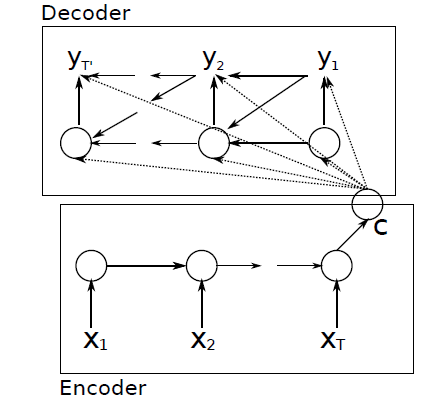

Finally, the loss function is computed in the following way:

$\begin{equation}
L_{attention} = - log(P(y|x))
\end{equation}$

You can find more about Attention-based encoder-decoder RNN models in the follwoing papers : [GRU-based AED in OHMER](https://arxiv.org/pdf/1712.03991v1.pdf), [Attention-based Models for SR by J. Chorowski *et al.*](https://papers.nips.cc/paper/2015/file/1068c6e4c8051cfd4e9ea8072e3189e2-Paper.pdf), [RNN encoder-decoder](https://arxiv.org/pdf/1406.1078.pdf?source=post_page---------------------------), [Joint CTC and AED in SR](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7953075), [AED in SR by D. Bahdanau *et al.*](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7472618).

> Regularisation

Regularisation is vital for good performance with RNNs, as their flexibility makes them prone to overfitting. RNN regularization's goal is any regularization's goal: maximizing information utility and traversal of the test loss function. The specific methods, however, tend to differ substantially for RNNs per their recurrent nature and some work better than others.
Below is a list of methods used for RNNs:


*   Weight Decay (general, Recurrent weights, kernel weights)
*   Weight Noise (with the addition of Gaussian noise to the network weights during training, [see paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=548170))
*   Dropout
*   Batch Normalisation
*   Residual RNNs
*   Zoneout, [see page](https://arxiv.org/abs/1606.01305).
*   Early Stopping.




Now let's try to train the model using the CTC method. Below is an attempt of training that I didn't manage to debug in time. It's simply to give you an idea, and if you are able to debug it, well, feel free to do so and change the code...



In [ ]:
X_train = torch.from_numpy(SpeechRec.X_train).to(torch.double)

class RNN(nn.Module):
    def __init__(self, output_size, input_size=161, hidden_size=28):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn1 = rnn = nn.RNN(input_size, hidden_size, num_layers=1, nonlinearity='tanh', batch_first=True, dropout=0, bidirectional=False).double()
        # if bidirectional, first arg in nn.Linear above must but be hidden_size * 2
        self.linear = nn.Linear(hidden_size, output_size)

        # FEEL FREE TO BUILD THE MODEL YOU PREFER (BLSTM, Deep BLSTM, GRU, etc...)

    def forward(self, input, future=0, hidden=None):
        # accept previous hidden state
        if hidden == None:
            hidden = torch.zeros(input.size(0), self.hidden_size, dtype=torch.double)
        # predict over the different signals
        outputs = []
        # for input_t in input.split(1, dim=0):
        for input_t in input:
            hidden = self.rnn1(input_t, hidden)
            output = self.linear(hidden)
            outputs += [output]
        for i in range(future):# if we should predict the future
            hidden = self.rnn1(output, hidden)
            output = self.linear(hidden)
            outputs += [output]
        outputs = torch.cat(outputs, dim=1)
        return outputs, hidden


In [ ]:
criterion = nn.CTCLoss(blank=28)
optimizer = optim.SGD(rnn.parameters(), lr=0.8)

In [ ]:
# training step through all data
def closure():
    optimizer.zero_grad()
    output, hidden = rnn(X_train)
    loss = criterion(output, torch.from_numpy(SpeechRec.y_train), torch.from_numpy(SpeechRec.xtrain_lengths), torch.from_numpy(SpeechRec.ytrain_lengths))
    print('loss:', loss.item())
    loss.backward()
    return loss

In [ ]:
optimizer.step(closure)

I am sorry I couldn't provide a working model, let alone an efficient one. I am therefore going to present in the next and final part some interesting results from some articles which unsurprisingly did a far better job than me.

# IV. Some results of RNN applied to Automatic Speech Recognition

In their paper exploring how RNNs can benefit from depth in space for ASR, [A. Graves *et al.*](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6638947) tested 9 different models, modifying the following aspects between them: the training method used (CTC, Transducer or pretrained Transducer), the number of hidden layers used (ranging from 1 to 5), the number of cells in each layer, the cell type used (BLSTM cells for all except one model with Tanh units, and another with unidirectional LSTMs). Weight noise and early stopping regularisations were used.
The PER (Phoneme Error Rate) showed some interesting results.

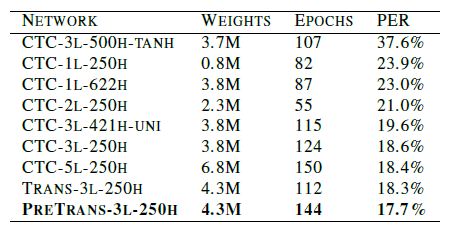

But this error rate is not the best achieved by RNNs. [Y. Miao *et al.*](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7404790) have achieved good results too, working with phoneme-based and character-based recognition:

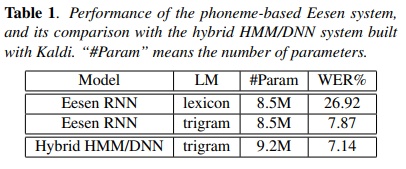

WER being the "Word Error Rate"

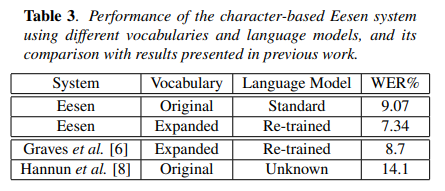

The A. Graves *et al.* paper mentioned in the above picture is the following : [see paper](http://proceedings.mlr.press/v32/graves14.pdf). Here's a summary of the results of this paper:

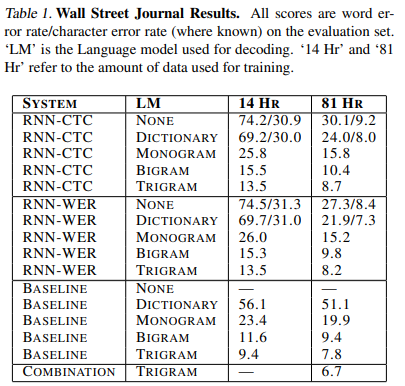

In the above picture, the numbers in the table are error rates (word or phoneme, depending on the model).



---



> The end - Thank you







